# Goal

We want to compare the stability of different numerical integration solutions. A few considerations:
- For simplicity, we only considered one dimensional functions, $\mathbb{R} \rightarrow \mathbb{R}$.
- We will vary the interval of integration using exponentially distributed endpoints, i.e. we calculate $\int_a^b$ with $a,b \sim Exp(1)$. This implies that $a,b \in \mathbb{R}^+$
- We will consider different test functions to compare the performance of the numerical integrator under different behaviours.
- We will NOT have singularities in any interval. Singularities might exist at $0$, such as with the test function $\sin ( x^{-1} )$


In [1]:
from dataclasses import dataclass
from typing import Callable

@dataclass
class TestFunction:
        name: str
        distribution: Callable[[float], float] # f(x)
        cumulative: Callable[[float], float] # F(x)
        
@dataclass
class Integrator:
        name: str
        integral: Callable[[Callable[[float], float], float, float], float]

# Test functions

In [2]:
import math
test_functions = [
        TestFunction(name="sin", distribution=math.sin, cumulative=lambda x: - 1 * math.cos(x)),
        TestFunction(name="quadratic", distribution=lambda x: x**2, cumulative=lambda x: x**3/3),
        TestFunction(name="asymmetric", distribution=lambda x: x**(-11), cumulative=lambda x: -1 * x**(-10)/10),
        TestFunction(name="step", distribution=lambda x: 1 if x<3 else 0, cumulative=lambda x: x if x<3 else 3)
]

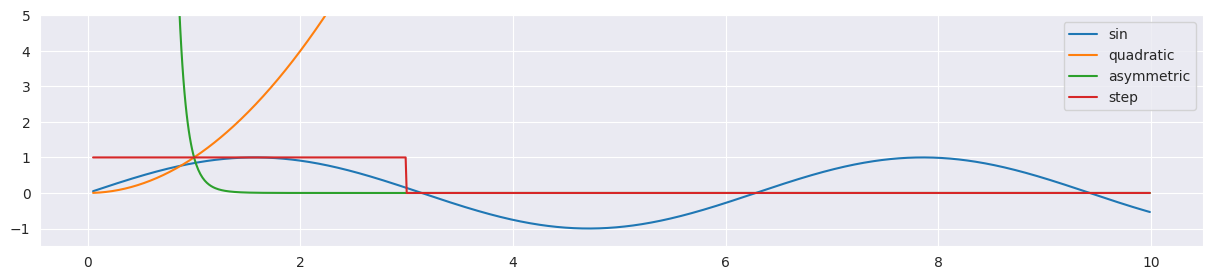

In [3]:
import matplotlib.pyplot as plt 
import numpy as np

x = np.arange(0.05,10,.01)
 
plt.figure(figsize=(15,3))
for function in test_functions:
        plt.plot(x, [function.distribution(z) for z in x], label = function.name)
plt.legend()
plt.ylim(-1.5, 5)
plt.show()

# Integrators

In [4]:
import scipy
integrators = [
        Integrator(name="scipy_quad", integral=lambda fun, a, b: scipy.integrate.quad(fun, a, b)[0]),
        Integrator(name="fixed_quad", integral=lambda fun, a, b: scipy.integrate.fixed_quad(lambda x: fun(x[0]), a, b)[0]),
        # IntegrationAlgorithm(name="scipy_qmc_quad", integral=lambda fun, a, b: scipy.integrate.qmc_quad(lambda (x,n): [fun(z) for z in x], [a], [b]).integral),
]

# Dataset creation

In [5]:
from itertools import product
from tqdm import tqdm
import pandas as pd
import numpy as np

df = pd.DataFrame(columns=["test_function", "integration_algorithm", "a", "b", "integral", "estimated_integral"])
n_samples = 1000
iterator = product(
        test_functions,
        integrators,
        np.random.exponential(1, size=(n_samples, 2))
)
total = len(test_functions) * len(integrators) * n_samples

for function, integrator, bounds in tqdm(iterator, total=total):
        
        lower_bound, upper_bound = min(bounds), max(bounds)
        df.loc[len(df.index)] = [
                function.name,
                integrator.name,
                lower_bound,
                upper_bound,
                function.cumulative(upper_bound) - function.cumulative(lower_bound),
                integrator.integral(function.distribution, lower_bound, upper_bound)
        ] 

100%|██████████| 8000/8000 [00:03<00:00, 2246.19it/s]


# Analysis of results

In [6]:
df["relative_error"] = (df["estimated_integral"] - df["integral"])/ df["integral"]
df.head()

,test_function,integration_algorithm,a,b,integral,estimated_integral,relative_error
0,sin,scipy_quad,0.692193,1.435326,0.634792,0.634792,1.748957e-16
1,sin,scipy_quad,0.199071,1.032381,0.467474,0.467474,-1.187470e-16
2,sin,scipy_quad,0.148988,0.357478,0.052140,0.052140,-2.661662e-16
3,sin,scipy_quad,0.149263,1.278902,0.701114,0.701114,0.000000e+00
4,sin,scipy_quad,0.036465,2.114742,1.516852,1.516852,0.000000e+00


# Relative errors

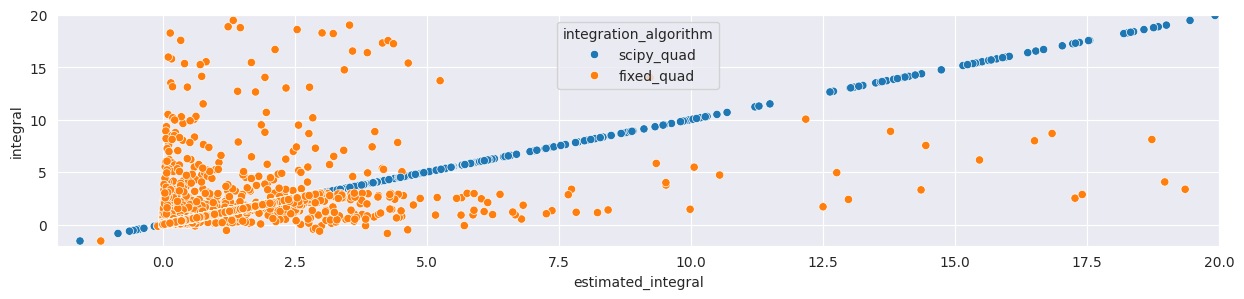

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,3))
sns.scatterplot(x='estimated_integral', y='integral', hue='integration_algorithm', data=df)
plt.xlim(-2,20)
plt.ylim(-2,20)
plt.show()

# Higher errors

Most of the integrals with high errors use the `fixed_quad` approach on the assymetric $x^{-10}$ function, which is natural given that the value of the integral explodes in that range

In [8]:
outliers = np.logical_or(df["relative_error"]<-.5, df["relative_error"]>.5)

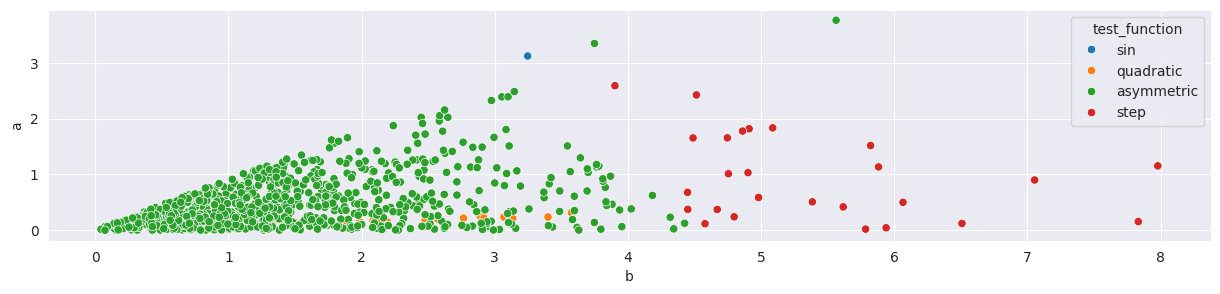

In [9]:
fig, ax = plt.subplots(figsize=(15,3))
sns.scatterplot(x='b', y='a', hue='test_function', data=df[outliers]) 
plt.show()

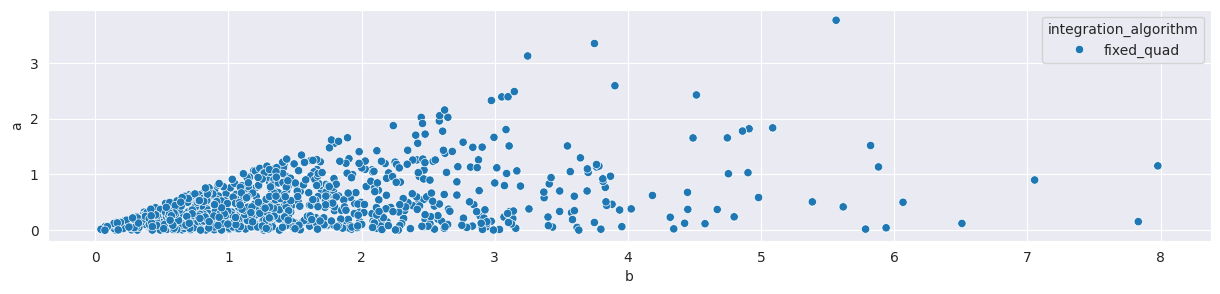

In [10]:
fig, ax = plt.subplots(figsize=(15,3))
sns.scatterplot(x='b', y='a', hue='integration_algorithm', data=df[outliers]) 
plt.show()